本文档用于处理GOES数据

In [3]:
import netCDF4 as nc
ff=nc.Dataset(r'D:\Learning\PHD1st\magnetic_reconnecion\data\GOES\sci_exis-l1b-sfxr_g16_d20240618_v0-0-1.nc' )
print(ff.variables.keys())  

dict_keys(['irradiance_xrsa1', 'irradiance_xrsa2', 'primary_xrsa', 'irradiance_xrsb1', 'irradiance_xrsb2', 'primary_xrsb', 'xrs_ratio', 'corrected_current_xrsa_1', 'corrected_current_xrsa_2', 'corrected_current_xrsa_3', 'corrected_current_xrsa_4', 'corrected_current_xrsb_1', 'corrected_current_xrsb_2', 'corrected_current_xrsb_3', 'corrected_current_xrsb_4', 'dispersion_angle', 'crossdispersion_angle', 'sc_power_side', 'exis_flight_model', 'exis_configuration_id', 'xrs_runctrlmd', 'integration_time', 'exs_sl_pwr_ena', 'asic1_temperature', 'asic2_temperature', 'invalid_flags', 'xrs_det_chg', 'xrs_mode', 'sps_obs_time', 'sps_int_time', 'sps_temperature', 'sps_det_chg', 'num_angle_pairs', 'yaw_flip_flag', 'au_factor', 'quality_flags', 'time', 'packet_count', 'fov_unknown', 'fov_eclipse', 'fov_lunar_transit', 'fov_planet_transit', 'fov_off_point', 'quaternion_Q0', 'quaternion_Q1', 'quaternion_Q2', 'quaternion_Q3', 'ecef_X', 'ecef_Y', 'ecef_Z', 'solar_array_current', 'SC_eclipse_flag', 'prod

In [4]:
import numpy as np
import cftime
import matplotlib.pyplot as plt
from datetime import datetime
import os
import requests
datetime0 = cftime.num2pydate(ff.variables["time"][:], ff["time"].units)
print("Filename:  ", 'sci_exis-l1b-sfxr_g16_d20240618_v0-0-1.nc')
print("start time in file [{}]: {}".format(ff["time"].units, ff.variables["time"][0]))
print("start and end times:", datetime0[0], datetime0[-1])

Filename:   sci_exis-l1b-sfxr_g16_d20240618_v0-0-1.nc
start time in file [seconds since 2000-01-01 12:00:00]: 771940800.8737149
start and end times: 2024-06-18 00:00:00.873715 2024-06-18 23:59:59.114898


In [3]:
s=ff.variables['time'][:]
print(21*3600)

75600


Text(0.5, 1.0, 'GOES 1-8$\\mathrm{\\AA}$')

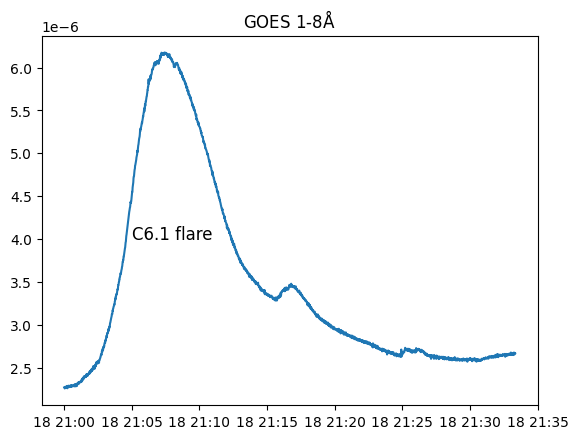

In [4]:
plt.plot(datetime0[75600:75600+2000],ff.variables['irradiance_xrsb1'][75600:75600+2000])
#plt.axvline(x=datetime0[76050],linestyle='--',color='black')
#plt.axvline(x=datetime0[76600],linestyle='--',color='black')
plt.text(x=datetime0[75900],y=4.0*10**-6,s='C6.1 flare',fontsize=12)
plt.title('GOES 1-8'+'$\mathrm{\AA}$')

In [5]:
print(datetime0[75642])
print(datetime0[77226])

2024-06-18 21:00:43.084890
2024-06-18 21:27:07.089316


In [6]:
print(77226-75642+1)

1585


In [7]:
print(np.linspace(0,133,1585))

[0.00000000e+00 8.39646465e-02 1.67929293e-01 ... 1.32832071e+02
 1.32916035e+02 1.33000000e+02]


画AIA的强度随时间变化曲线

In [5]:
import glob
from astropy.io import fits
file_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA2\193\*.fits')
value=np.zeros(len(file_list))
value2=np.zeros(len(file_list))#这个value2是除曝光时间，然后画出来曲线变化，但是发现他也没有想象中的那么连续
exptime=np.zeros(len(file_list))
for i in range(len(file_list)):
    rsm=fits.open(file_list[i])
    expt=rsm[1].header['EXPTIME']
    exptime[i]=expt
    value[i]=rsm[1].data.mean()
    value2[i]=rsm[1].data.mean()/expt



AIA131全日面光变曲线

Text(0.5, 1.0, '除曝光时长的光变曲线')

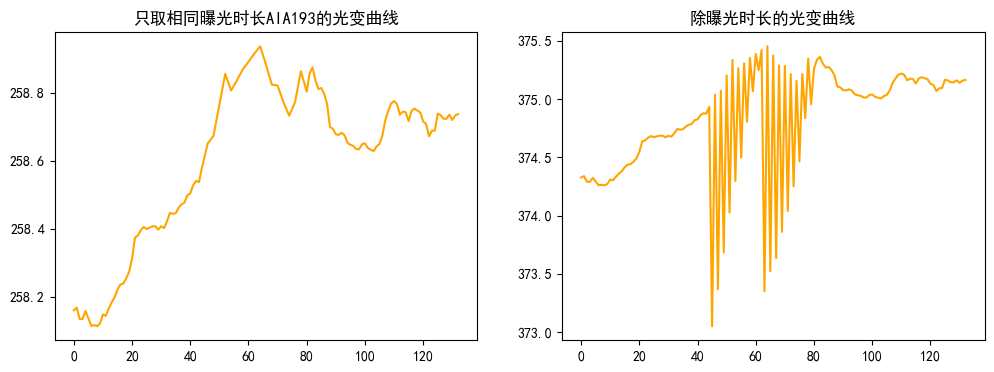

In [8]:
value[exptime<1.99]=np.NaN
from scipy.interpolate import interp1d
data=value
x=np.arange(len(data))
# 找到有效数据点
valid_idx = ~np.isnan(data)
x_valid = x[valid_idx]
y_valid = data[valid_idx]

# 线性插值
interp_func = interp1d(x_valid, y_valid, kind='linear', fill_value="extrapolate")
data_filled = interp_func(x)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 画出原始数据（带空缺）和插值后的数据
# plt.plot(x, data, 'ro', label="Original Data (with NaNs)")
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x[:133], data_filled[:133], color='orange',linestyle='-', label="Interpolated Curve")
plt.title('只取相同曝光时长AIA193的光变曲线')
plt.subplot(122)
plt.plot(x[:133],value2[:133]*2.9,color='orange',linestyle='-')
plt.title('除曝光时长的光变曲线')

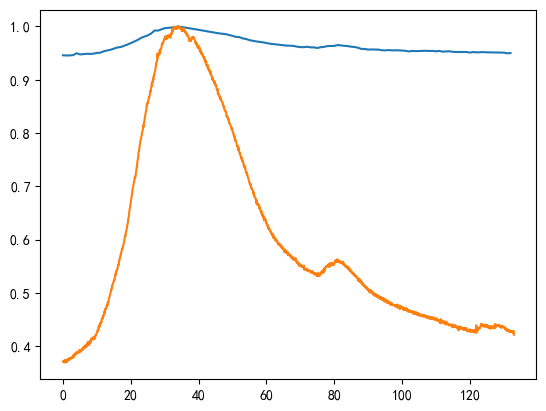

In [10]:

plt.plot(np.arange(0,133),data_filled[:133]/np.max(data_filled[:133]))
plt.plot(np.linspace(0,133,1585),ff.variables['irradiance_xrsb1'][75642:75642+1585]/np.max(ff.variables['irradiance_xrsb1'][75642:75642+1585]))

看一下几个波段在目标区域的光变曲线

In [10]:
#这里dir1是pre_131.sav的目录对应0-31，dir2是131.sav的目录对应32-132，exptime是长148的观测时间
def aia_intensity_curve(dir1,dir2,exptime,wavelenth):
    from scipy.io import readsav
    #这部分先把数据读入进来
    matrices=[]
    data1=readsav(dir1)
    matrix_struct=data1['matrix_struct']
    for i,entry in enumerate(matrix_struct):
        matrix=entry['matrix']
        matrices.append(matrix)
    matrices=matrices[69:]
    data2=readsav(dir2)
    matrix_struct=data2['matrix_struct']
    for i,entry in enumerate(matrix_struct):
        matrix=entry['matrix']
        matrices.append(matrix)
    #计算平均强度
    intensity=np.zeros(133)
    for i in range(133):
        intensity[i]=np.average(matrices[i])
    #这里去掉曝光时间不一致的点，131和193单独处理
    if wavelenth=='131' or '193':
        threshold=2.90 if wavelenth=='131' else 1.99
        intensity[exptime[:133]<threshold]=np.nan
        #把去掉的点用插值函数补上
        x=np.arange(133)
        valid_x=x[~np.isnan(intensity)]
        valid_intensity=intensity[~np.isnan(intensity)]
        f=interp1d(valid_x,valid_intensity,kind='linear')
        intensity[np.isnan(intensity)]=f(x[np.isnan(intensity)])
    #归一化
    intensity=(intensity-np.min(intensity))/(np.max(intensity)-np.min(intensity))
    return intensity

In [12]:
intensity=np.zeros((7,133))
name_list=['.94','131','171','193','211','304','335']

for i in range(7):
    file_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA2\\'+name_list[i]+'*.fits')
    exptime=np.zeros(len(file_list))
    for j in range(len(file_list)):
        rsm=fits.open(file_list[j])
        exptime[j]=rsm[0].header['EXPTIME']
    dir1=r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA2\pre_'+name_list[i]+'.sav'
    dir2=r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA2\\'+name_list[i]+'.sav'
    intensity[i,:]=aia_intensity_curve(dir1,dir2,exptime[:133],name_list[i])

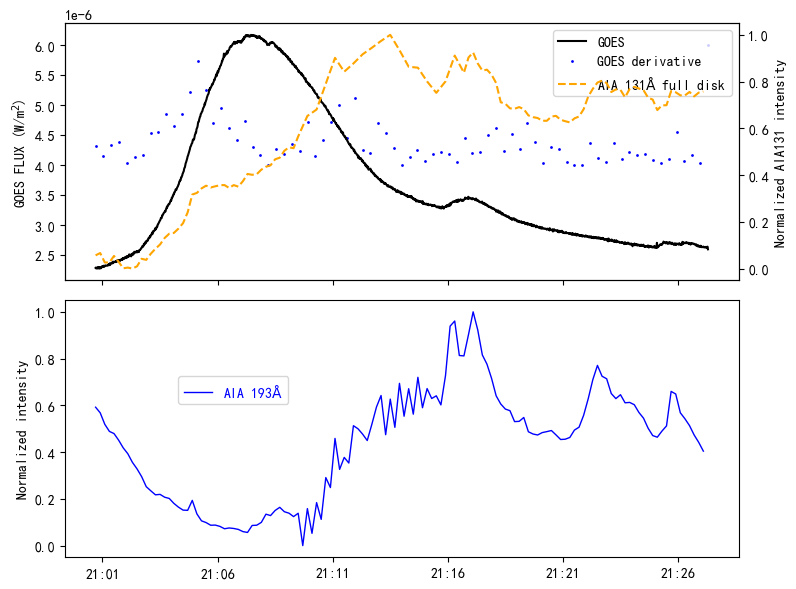

In [13]:
from scipy.interpolate import splprep, splev
from scipy.ndimage import zoom
corr_x=np.zeros(6)
#第一个时刻对应21：00：42，最后一个时刻对应21：27：06
for i in range(len(corr_x)):
    corr_x[i]=(i*300+18)/12
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
#y为GOES值
goes_x=np.linspace(0,133,1585)
goes_y=ff.variables['irradiance_xrsb1'][75642:75642+1585]
#求导，缩并
dy_dx=np.gradient(goes_y,goes_x)
dy_dx_reduced=zoom(dy_dx,0.05)

ax1.plot(goes_x,goes_y,color='black',label='GOES')
der_goes=abs(dy_dx_reduced)
der_goes2=(der_goes-np.min(der_goes))/(np.max(der_goes)-np.min(der_goes))
ax1.scatter(np.linspace(0,133,len(dy_dx_reduced)),(der_goes2+2)*1e-6*2,color='blue',s=1,label='GOES derivative')
ax1.set_ylabel('GOES FLUX (W/m$^2$)')
ax1b=ax1.twinx()
ax1b.set_ylabel('Normalized AIA131 intensity')
ax1b.plot(np.arange(0,133),(data_filled[:133]-np.min(data_filled[:133]))/(np.max(data_filled[:133])-np.min(data_filled[:133])),
          color='orange',linestyle='--',label='AIA 131$\mathrm{\AA}$ full disk')
# 获取 ax1 和 ax1b 各自的 legend 信息
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax1b.get_legend_handles_labels()

# 合并 handles 和 labels，统一显示在 ax1 上
ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')

name_list=['AIA 94$\mathrm{\AA}$','AIA 131$\mathrm{\AA}$',
           'AIA 171$\mathrm{\AA}$','AIA 193$\mathrm{\AA}$',
           'AIA 211$\mathrm{\AA}$','AIA 304$\mathrm{\AA}$','AIA 335$\mathrm{\AA}$']
lines=[]
linstyle=['-','-']
color=['green','orange','deepskyblue','blue','red','purple','brown']
for i in range(7):
    if i==3:
        line,=ax2.plot(intensity[i,:],color=color[i],label=name_list[i],linewidth=1,linestyle=linstyle[i%2])
        lines.append(line)
legend=ax2.legend(loc='center', bbox_to_anchor=(0.25, 0.65))
for text,line in zip(legend.get_texts(),lines):
    #print(line.get_color())
    text.set_color(line.get_color())
ax2.set_ylabel('Normalized intensity')
ax2.set_xticks(ticks=corr_x,labels=['21:01','21:06','21:11','21:16','21:21','21:26'])
plt.tight_layout()

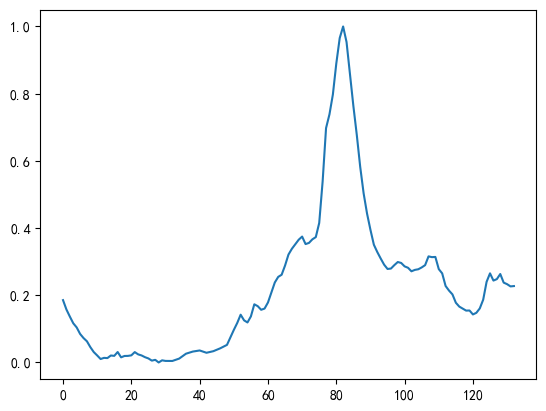

In [14]:
intenty111=aia_intensity_curve(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA2\pre_131.sav',r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA2\131.sav',exptime)
plt.plot(intenty111)

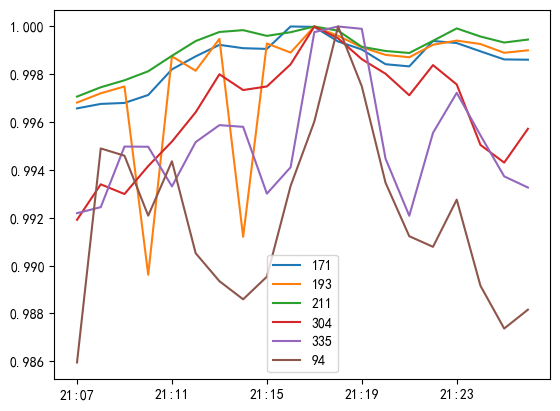

In [15]:
from scipy.io import readsav
dir=r'D:\Learning\PHD1st\magnetic_reconnecion\data_process\aia_int.sav'
aia_int=readsav(dir)
aia_int=aia_int['aia_int']
aia_new=np.zeros((20,7))
name_list=['131','171','193','211','304','335','94']
for i in range(1,7):
    aia_new[:,i]=aia_int[:,i]/np.max(aia_int[:,i])
    plt.plot(aia_new[:,i],label=name_list[i])
plt.legend()
plt.xticks(ticks=[0,4,8,12,16],labels=['21:07','21:11','21:15','21:19','21:23'])
plt.show()

['control_index', 'time', 'timedel', 'triggers', 'triggers_comp_err', 'rcr', 'counts', 'counts_comp_err']


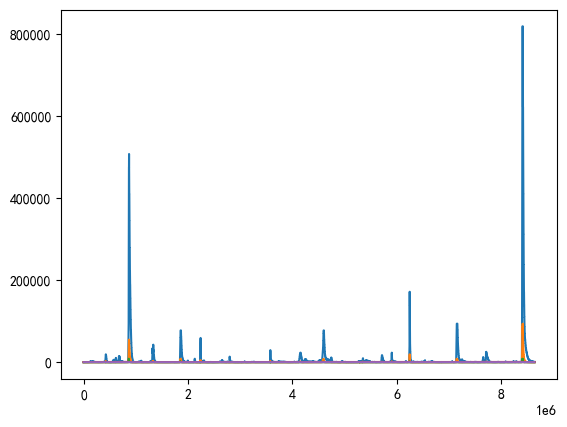

In [16]:
from astropy.io import fits
dir=r'D:\Learning\PHD1st\magnetic_reconnecion\data\HMI\B_rpt\solo_L1_stix-ql-lightcurve_20240319_V02.fits'
rsm=fits.open(dir)
data=rsm[2].data
print(data.columns.names)
plt.plot(data['time'],data['counts'])

In [17]:
time=data['time']
counts=data['counts']

In [18]:
print(24*3600/4)
print(data.shape)

21600.0
(21600,)
